# Mood-Based Playlist Generator: A Music Recommendation System

* Build a playlist recommendation system that suggests songs based on mood categories
* Use clustering models to group songs by mood, leveraging acoustic features (valence, energy, tempo).
* Personalize playlists by allowing users to input their mood, and get dynamic song recommendations.

# Business Understanding

# Data Understanding

In [66]:
pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from textblob import TextBlob
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz
from sklearn.decomposition import PCA

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning) 

In [72]:
df=pd.read_csv('./df_with_genres.csv')
df

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist,genre
0,0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future,rap
1,1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino,NaN
2,2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future,rap
3,3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House,dream pop
4,4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys,"alternative dance, indie electronic"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise,"dubstep, melodic bass, edm"
2013,2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis,"moombahton, edm, electro house"
2014,2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man,future bass
2015,2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons,dubstep


In [73]:
df.columns

Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist', 'genre'],
      dtype='object')

In [4]:
df.shape

(2017, 17)

In [11]:
df.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


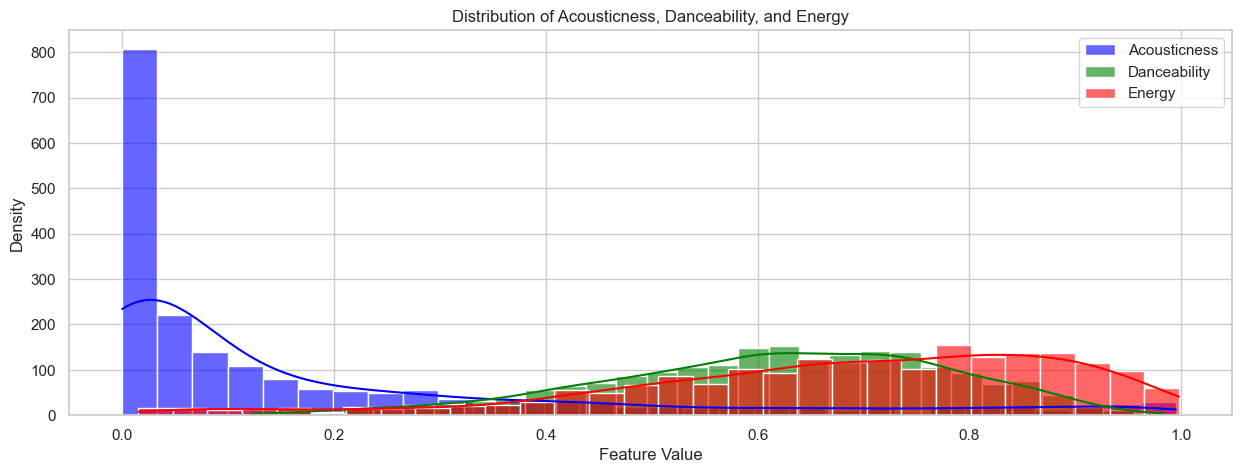

In [75]:
# Set visualization style
sns.set(style="whitegrid")

# Plot distributions
plt.figure(figsize=(15, 5))
sns.histplot(df["acousticness"], bins=30, kde=True, color="blue", label="Acousticness", alpha=0.6)
sns.histplot(df["danceability"], bins=30, kde=True, color="green", label="Danceability", alpha=0.6)
sns.histplot(df["energy"], bins=30, kde=True, color="red", label="Energy", alpha=0.6)
plt.legend()
plt.title("Distribution of Acousticness, Danceability, and Energy")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.show()

### Visualize Distribution of Artists and Songs

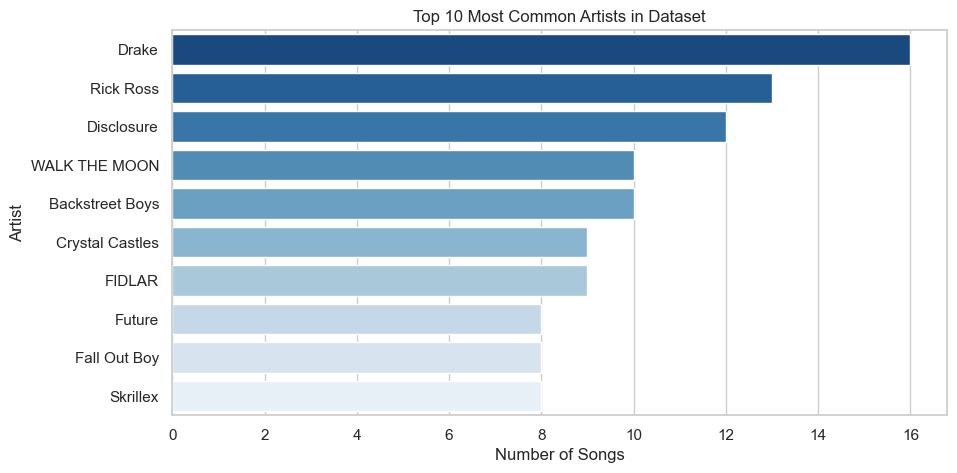

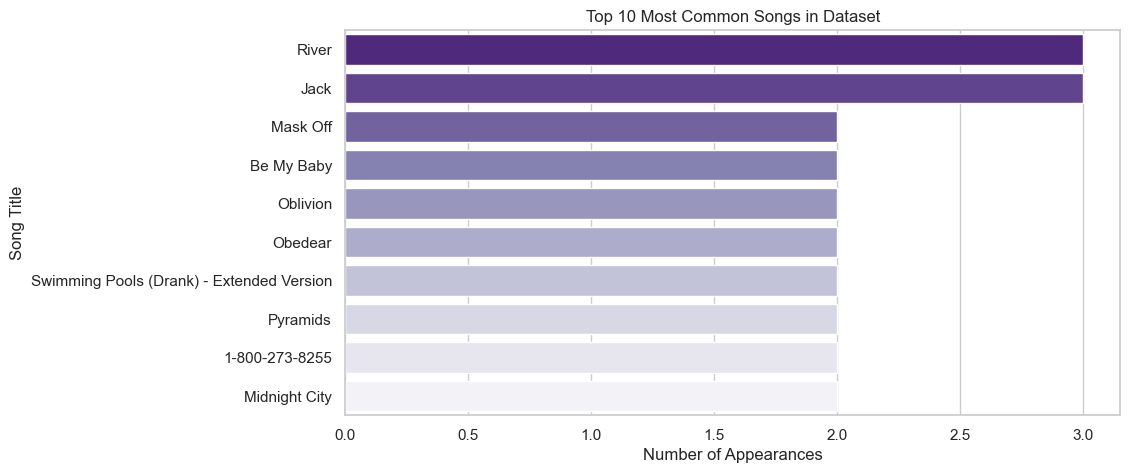

In [77]:
# Count top 10 most common artists
top_artists = df["artist"].value_counts().head(10)

# Count top 10 most common songs
top_songs = df["song_title"].value_counts().head(10)

# Plot top 10 artists
plt.figure(figsize=(10, 5))
sns.barplot(y=top_artists.index, x=top_artists.values, palette="Blues_r")
plt.title("Top 10 Most Common Artists in Dataset")
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.show()

# Plot top 10 songs
plt.figure(figsize=(10, 5))
sns.barplot(y=top_songs.index, x=top_songs.values, palette="Purples_r")
plt.title("Top 10 Most Common Songs in Dataset")
plt.xlabel("Number of Appearances")
plt.ylabel("Song Title")
plt.show()


# Data Preparation

### Drop Unnamed, Target, Mode, Duration and columns

In [180]:
# Drop Unnamed and Target columns
df = df.drop(columns=["Unnamed: 0", "target","mode","duration_ms"], errors="ignore")

### Correlation between features

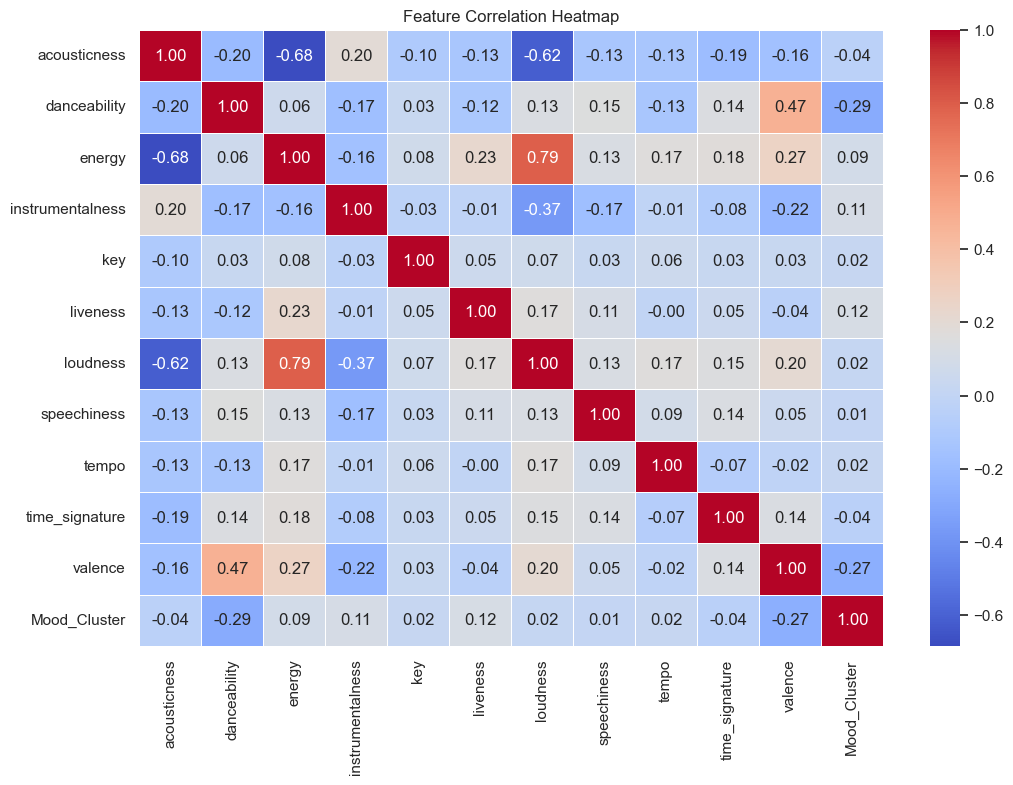

In [181]:
# Exclude "Unnamed: 0" and select only numeric columns
numeric_df = df.select_dtypes(include=['number'])
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Drop Energy column
Since energy and loudness are highly correlated and energy and acousticness are highly correlated, I will drop energy as we are already getting similar information from the other features.

In [182]:
# Drop energy
df = df.drop(columns=["energy"], errors="ignore")

### Check for null values

In [183]:
# Check for missing values
df.isnull().sum()

acousticness        0
danceability        0
instrumentalness    0
key                 0
liveness            0
loudness            0
speechiness         0
tempo               0
time_signature      0
valence             0
song_title          0
artist              0
genre               0
Mood_Cluster        0
dtype: int64

In [184]:
# Drop rows with any null values
df.dropna(inplace=True)

# Verify that there are no more missing values
print(df.isnull().sum())

acousticness        0
danceability        0
instrumentalness    0
key                 0
liveness            0
loudness            0
speechiness         0
tempo               0
time_signature      0
valence             0
song_title          0
artist              0
genre               0
Mood_Cluster        0
dtype: int64


### Drop "Unknown" genre

In [185]:
df.genre.value_counts()

genre
rap                                      40
country                                  36
jazz                                     28
house                                    22
rap, hip hop                             20
                                         ..
retro soul, soul                          1
reggae, roots reggae                      1
rap rock, east coast hip hop, hip hop     1
glitch, nu jazz                           1
moombahton, edm, electro house            1
Name: count, Length: 566, dtype: int64

In [186]:
df = df[~df["genre"].str.strip().str.lower().eq("unknown")]

In [178]:
df.genre.value_counts()

genre
rap                                      40
country                                  36
jazz                                     28
house                                    22
rap, hip hop                             20
                                         ..
retro soul, soul                          1
reggae, roots reggae                      1
rap rock, east coast hip hop, hip hop     1
glitch, nu jazz                           1
moombahton, edm, electro house            1
Name: count, Length: 566, dtype: int64

In [188]:
df.shape

(1318, 14)

We are still left with 1318 songs which is enough to create enough playlists for our purposes.

### Drop duplicate songs
It looks like there are some duplicate songs in the data set. We will keep only one version if it has the same title and artist.

In [189]:
# Drop duplicate songs/ remixes
df = df.drop_duplicates(subset=["song_title", "artist"], keep="first").reset_index(drop=True)

In [190]:
#Check if there are any more duplicates
df.duplicated(subset=["song_title", "artist"], keep=False).sum()

0

In [191]:
df.shape

(1294, 14)

### Split grenres into seperate columns

In [192]:
# Split genre column into multiple one-hot encoded columns
df_genre_encoded = df["genre"].str.get_dummies(sep=", ")

# Merge back with original dataset
df_encoded = pd.concat([df, df_genre_encoded], axis=1)

# Drop the original 'genre' column (optional)
df_encoded.drop(columns=["genre"], inplace=True)

In [193]:
df_encoded

,acousticness,danceability,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,...,uk garage,underground hip hop,urbano latino,vallenato,vaporwave,variété française,vocal jazz,west coast hip hop,witch house,worship
0,0.01020,0.833,0.021900,2,0.1650,-8.795,0.4310,150.062,4.0,0.286,...,0,0,0,0,0,0,0,0,0,0
1,0.03440,0.838,0.000234,2,0.1590,-7.148,0.2890,75.044,4.0,0.173,...,0,0,0,0,0,0,0,0,0,0
2,0.60400,0.494,0.510000,5,0.0922,-15.236,0.0261,86.468,4.0,0.230,...,0,0,0,0,0,0,0,0,0,0
3,0.18000,0.678,0.512000,5,0.4390,-11.648,0.0694,174.004,4.0,0.904,...,0,0,0,0,0,0,0,0,0,0
4,0.00479,0.804,0.000000,8,0.1640,-6.682,0.1850,85.023,4.0,0.264,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,0.00231,0.624,0.121000,6,0.2550,-0.935,0.0643,102.003,4.0,0.442,...,0,0,0,0,0,0,0,0,0,0
1290,0.00106,0.584,0.002690,1,0.1290,-3.501,0.3330,74.976,4.0,0.211,...,0,0,0,0,0,0,0,0,0,0
1291,0.08770,0.894,0.001670,1,0.0528,-2.663,0.1310,110.041,4.0,0.867,...,0,0,0,0,0,0,0,0,0,0
1292,0.00857,0.637,0.003990,0,0.2140,-2.467,0.1070,150.082,4.0,0.470,...,0,0,0,0,0,0,0,0,0,0


### Take only 20 top genres

In [196]:
# Get the top 20 most common genres
top_genres = df["genre"].str.split(", ").explode().value_counts().index[:20]

# Create one-hot encoding only for the top genres
df_genre_encoded = df["genre"].str.get_dummies(sep=", ")[top_genres]

# Merge with the original dataset
df_encoded = pd.concat([df, df_genre_encoded], axis=1)

# Drop original genre column
df_encoded.drop(columns=["genre"], inplace=True)

### Select only the features we will use for clustering

In [26]:
# Select relevant features for clustering
cluster_features = ['valence', 'tempo', 'danceability', 'acousticness', 'instrumentalness', 'liveness', 'speechiness','genre']
df_features = df[acoustic_features]

### One Hot Encode Genre

In [197]:
# One-hot encode only the top genres
df_genre_encoded = df["genre"].str.get_dummies(sep=", ")[top_genres]

# Merge with the original dataset
df_encoded = pd.concat([df, df_genre_encoded], axis=1)

# Drop the original genre column
df_encoded.drop(columns=["genre"], inplace=True)

### Scale features

In [201]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select numeric features (excluding song title & artist)
features = df_encoded.drop(columns=["song_title", "artist"])

# Scale the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(features)

### Finding Optimal Number of Clusters for KMeans

k=2, Inertia=36592.157132961496
k=3, Inertia=33318.830541526964
k=4, Inertia=29603.64324619494
k=5, Inertia=27808.98115463913
k=6, Inertia=26501.726677138307
k=7, Inertia=24375.659580046864
k=8, Inertia=23787.948965587086
k=9, Inertia=21182.858054390523
k=10, Inertia=19571.353463321597


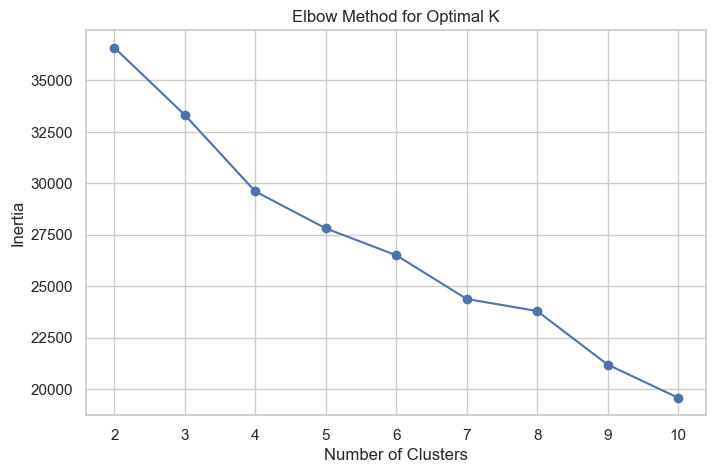

In [204]:
# Determine optimal number of clusters using Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', algorithm='elkan')
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    print(f'k={k}, Inertia={kmeans.inertia_}')  # Print inertia values

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### KMeans - 6 clusters

In [219]:
# Set optimal k
optimal_k = 6

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_encoded["Mood_Cluster"] = kmeans.fit_predict(df_scaled)

In [220]:
# Evaluate clusters using Silhouette Score
silhouette_avg = silhouette_score(df_scaled, df_encoded["Mood_Cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.2893


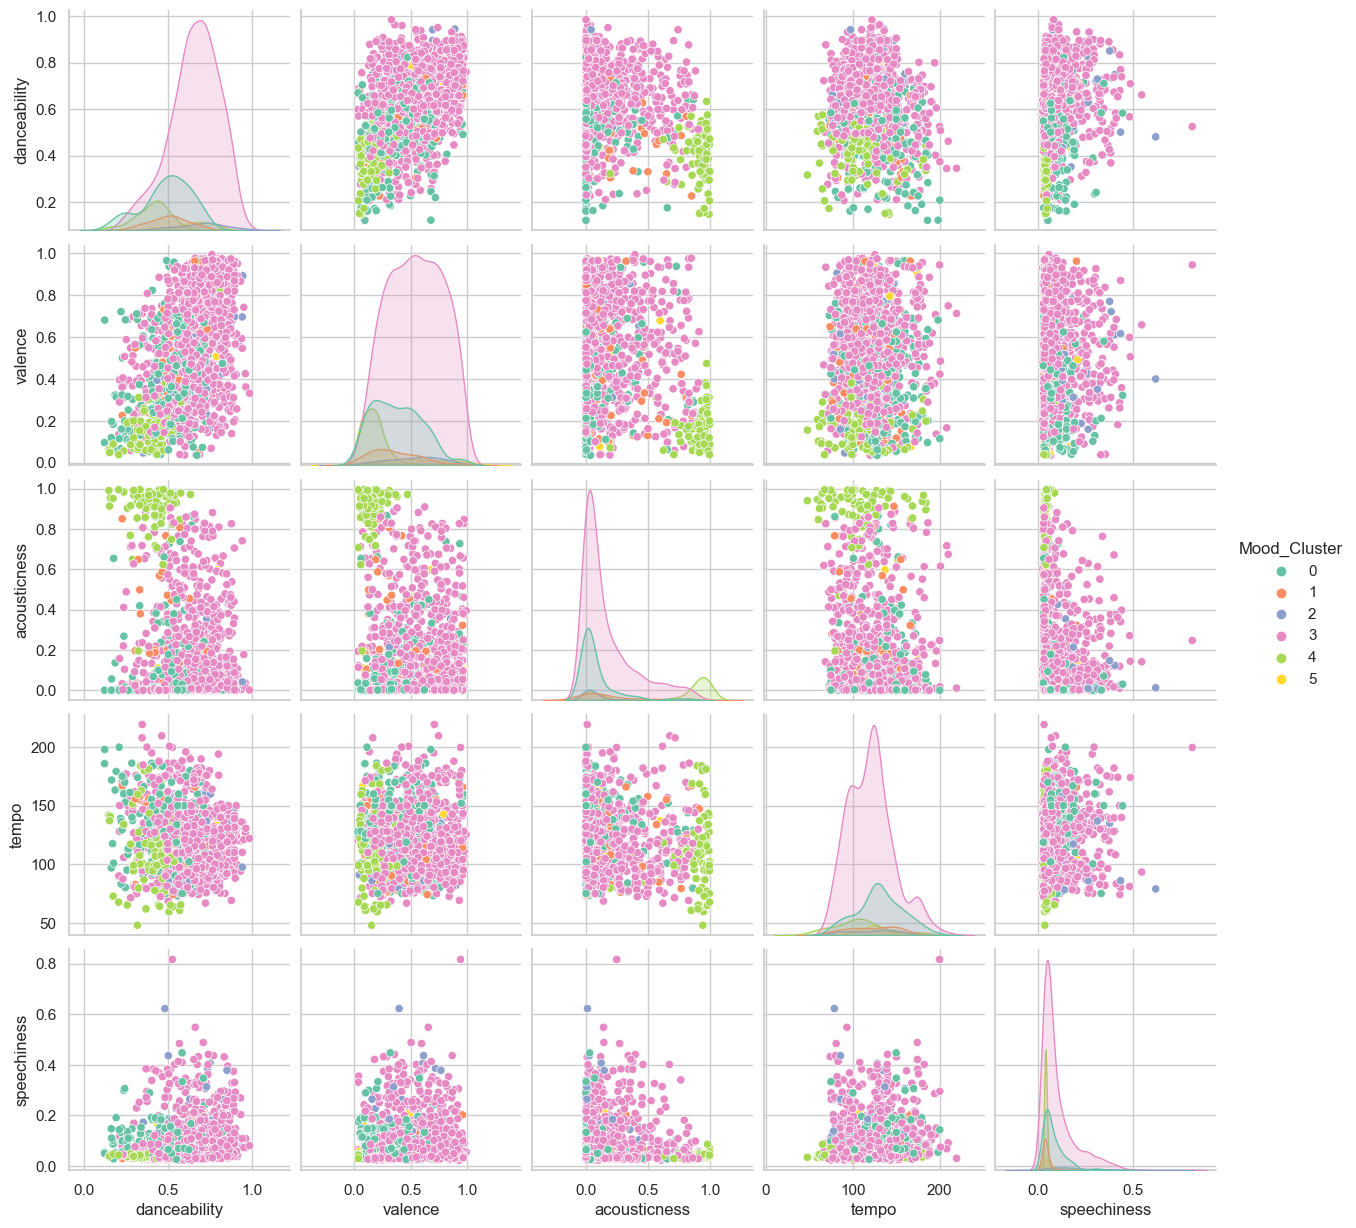

In [221]:
features = ["danceability", "valence", "acousticness", "tempo", "speechiness"]

sns.pairplot(df_encoded, vars=features, hue="Mood_Cluster", palette="Set2", diag_kind="kde")
plt.show()

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_34052\4109453394.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_genres = genre_counts.groupby("Mood_Cluster", group_keys=False).apply(lambda x: x.nlargest(5, "Count"))


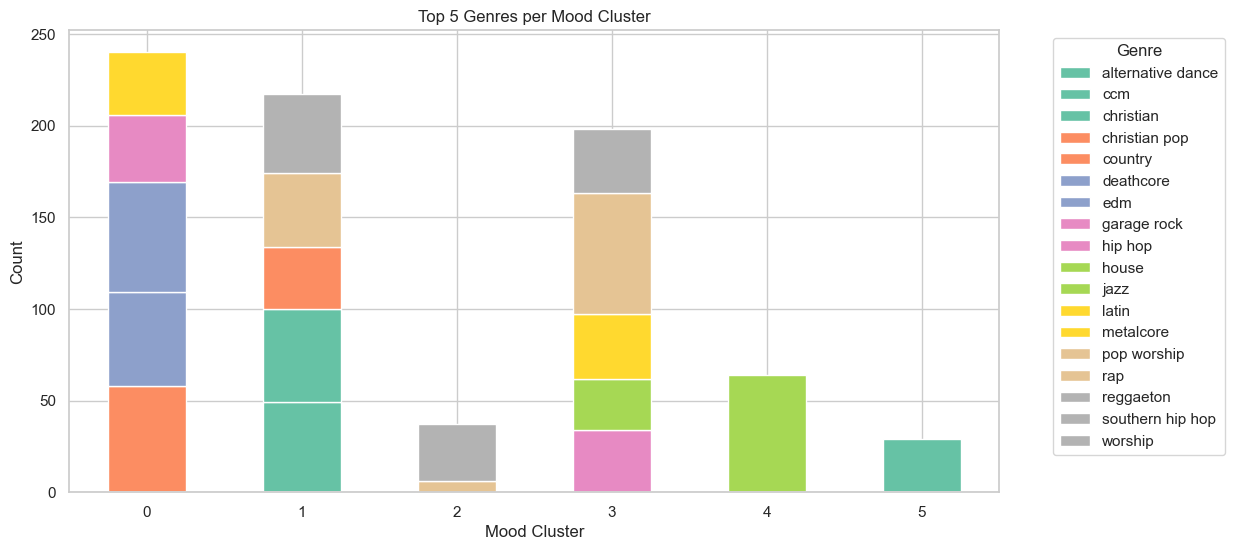

In [224]:
# Melt the genre columns to long format for visualization
genre_columns = df_encoded.columns[11:-1]  # Adjust index based on your dataset
df_genre_melted = df_encoded.melt(id_vars=["Mood_Cluster"], value_vars=genre_columns, var_name="Genre", value_name="Presence")

# Filter to only present genres
df_genre_melted = df_genre_melted[df_genre_melted["Presence"] == 1]

# Count occurrences of each genre in each cluster
genre_counts = df_genre_melted.groupby(["Mood_Cluster", "Genre"]).size().reset_index(name="Count")

# Get top 5 genres per cluster (ensuring all clusters are included)
top_genres = genre_counts.groupby("Mood_Cluster", group_keys=False).apply(lambda x: x.nlargest(5, "Count"))

# Pivot for stacked bar plot (ensuring all clusters appear)
all_clusters = sorted(df_encoded["Mood_Cluster"].unique())
top_genres_pivot = top_genres.pivot(index="Mood_Cluster", columns="Genre", values="Count").reindex(all_clusters, fill_value=0)

# Plot
top_genres_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="Set2")
plt.title("Top 5 Genres per Mood Cluster")
plt.xlabel("Mood Cluster")
plt.ylabel("Count")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.show()

### Trying 5 Clusters - KMeans

In [225]:
# Set optimal k
optimal_k = 5

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
df_encoded["Mood_Cluster"] = kmeans.fit_predict(df_scaled)

In [226]:
# Evaluate clusters using Silhouette Score
silhouette_avg = silhouette_score(df_scaled, df_encoded["Mood_Cluster"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.2739


### PCA
Since we have over 300 genres, we will only keep the 10 most important.

In [227]:
# Select numeric features only (excluding song_title, artist, and target cluster)
features = df_encoded.drop(columns=["song_title", "artist", "Mood_Cluster"])

# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [228]:
# Initialize PCA
pca = PCA(n_components=0.95)  # Retains 95% of variance
principal_components = pca.fit_transform(features_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])

# Add back song titles, artists, and clusters
df_pca["song_title"] = df_encoded["song_title"].values
df_pca["artist"] = df_encoded["artist"].values
df_pca["Mood_Cluster"] = df_encoded["Mood_Cluster"].values

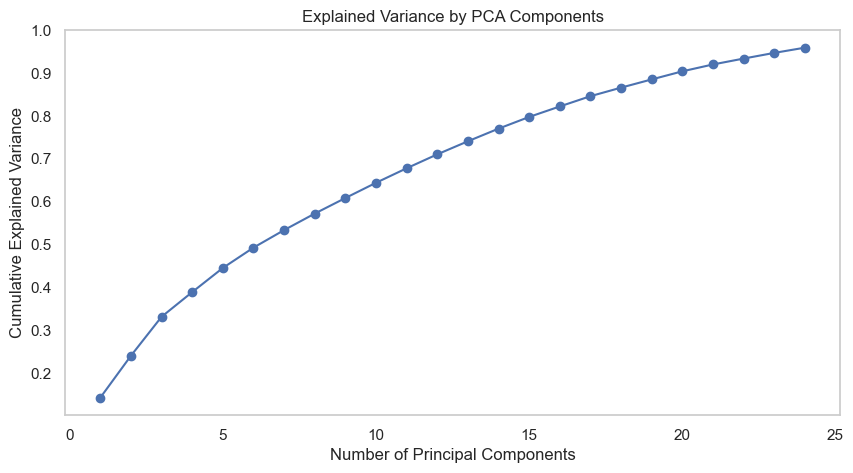

In [229]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker="o")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid()
plt.show()

In [234]:
# Choose the number of clusters (adjust based on your elbow method or domain knowledge)
num_clusters = 6  # Change this if needed

# Fit K-Means on PCA-transformed data
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42, n_init="auto")
df_pca["Cluster"] = kmeans_pca.fit_predict(df_pca.iloc[:, :-3])  # Exclude song_title, artist, and Mood_Cluster

# Calculate Silhouette Score
silhouette_avg = silhouette_score(df_pca.iloc[:, :-3], df_pca["Cluster"])
print(f"Silhouette Score with {num_clusters} clusters: {silhouette_avg:.4f}")

Silhouette Score with 6 clusters: 0.3103


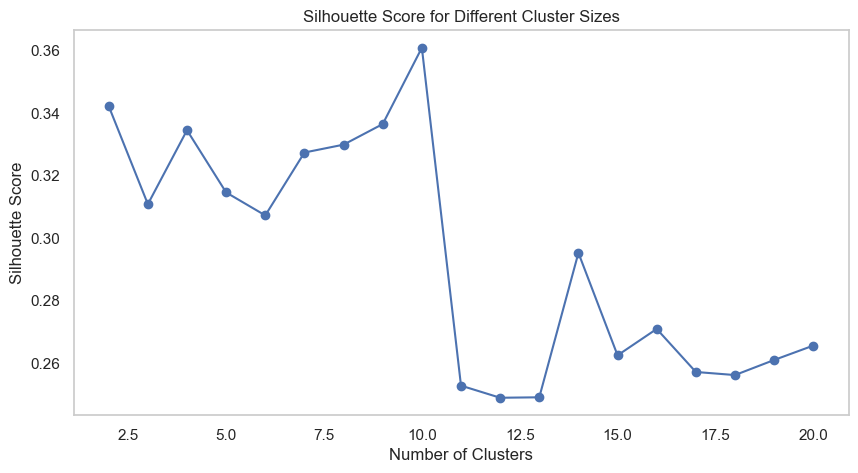

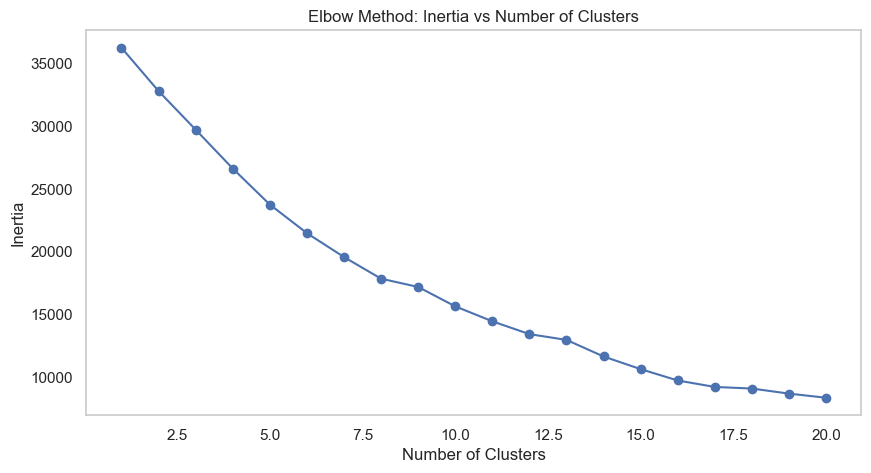

In [240]:
silhouette_scores = []
inertia_scores = []
cluster_range = range(1, 21)  # Testing from 1 to 20 clusters

for k in cluster_range:
    if k == 1:
        # Silhouette score is not defined for k=1
        silhouette_scores.append(None)
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        kmeans.fit(df_pca.iloc[:, :-3])
        inertia_scores.append(kmeans.inertia_)
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = kmeans.fit_predict(df_pca.iloc[:, :-3])
        silhouette_scores.append(silhouette_score(df_pca.iloc[:, :-3], labels))
        inertia_scores.append(kmeans.inertia_)

# Plot Silhouette Score vs. Number of Clusters
plt.figure(figsize=(10, 5))
plt.plot(cluster_range[1:], silhouette_scores[1:], marker="o", linestyle="-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Cluster Sizes")
plt.grid()
plt.show()

# Plot Inertia vs. Number of Clusters
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia_scores, marker="o", linestyle="-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method: Inertia vs Number of Clusters")
plt.grid()
plt.show()

In [241]:
# Set the number of clusters to 10
kmeans = KMeans(n_clusters=10, random_state=42, n_init="auto")
labels = kmeans.fit_predict(df_pca.iloc[:, :-3])

# Compute silhouette score
silhouette_avg = silhouette_score(df_pca.iloc[:, :-3], labels)
print(f"Silhouette Score for 10 Clusters: {silhouette_avg:.4f}")

Silhouette Score for 10 Clusters: 0.3609


### TryGaissian Mixture Models (GMM) instead of KMeans

In [245]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=10, random_state=42)
labels_gmm = gmm.fit_predict(df_pca.iloc[:, :-3])

print(f"Silhouette Score (GMM): {silhouette_score(df_pca.iloc[:, :-3], labels_gmm):.4f}")

Silhouette Score (GMM): 0.3022


### Try Agglomerative Clustering instead of KMeans

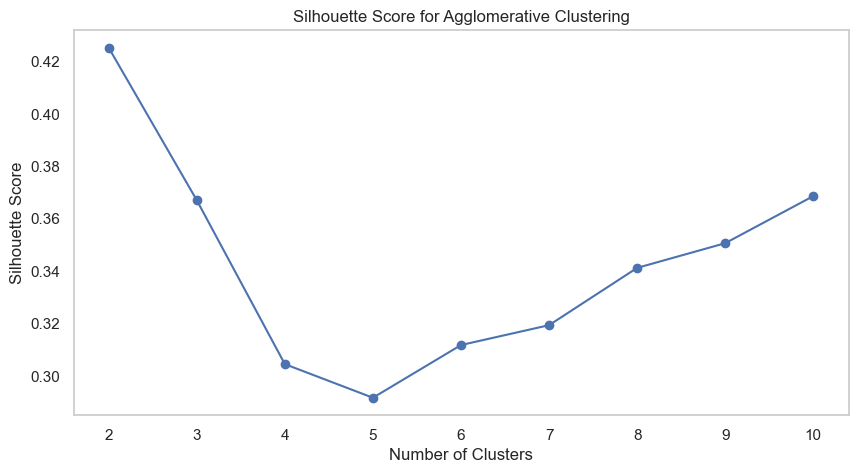

In [246]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
silhouette_scores = []
cluster_range = range(2, 11)  # Testing from 2 to 10 clusters

for k in cluster_range:
    agglomerative = AgglomerativeClustering(n_clusters=k)
    labels = agglomerative.fit_predict(df_pca.iloc[:, :-3])  # Use PCA data
    
    score = silhouette_score(df_pca.iloc[:, :-3], labels)
    silhouette_scores.append(score)

# Plot Silhouette Score vs. Number of Clusters
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker="o", linestyle="-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Agglomerative Clustering")
plt.grid()
plt.show()


In [247]:
best_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Best number of clusters: {best_k}")

# Fit Agglomerative Clustering with the best `k`
agglomerative = AgglomerativeClustering(n_clusters=best_k)
df_pca["Agglo_Cluster"] = agglomerative.fit_predict(df_pca.iloc[:, :-3])

# Show some sample clusters
df_pca[["song_title", "artist", "Agglo_Cluster"]].head(10)

Best number of clusters: 2


,song_title,artist,Agglo_Cluster
0,Mask Off,Future,0
1,Xanny Family,Future,0
2,Master Of None,Beach House,0
3,Parallel Lines,Junior Boys,0
4,Sneakin’,Drake,0
5,Childs Play,Drake,0
6,Gyöngyhajú lány,Omega,0
7,I've Seen Footage,Death Grips,0
8,Donme Dolap - Baris K Edit,Modern Folk Üçlüsü,0
9,Cemalim,Erkin Koray,0


In [253]:
# Select only numeric PCA components for scoring
numeric_columns = [col for col in df_pca.columns if col.startswith("PC")]  # Keep only PCA components
numeric_pca_data = df_pca[numeric_columns]  # Select only PCA components

# Compute Silhouette Score
score = silhouette_score(numeric_pca_data, df_pca["Agglo_Cluster"])

print(f"Silhouette Score for Agglomerative Clustering (k={best_k}): {score:.4f}")

Silhouette Score for Agglomerative Clustering (k=2): 0.4252


### Try DBSCAN (Density-Based Clustering)

In [254]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Try different values of eps (distance threshold)
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust `eps` and `min_samples` as needed
df_pca["DBSCAN_Cluster"] = dbscan.fit_predict(numeric_pca_data)

# Check if clustering is meaningful (DBSCAN assigns -1 to noise)
if len(set(df_pca["DBSCAN_Cluster"])) > 1:
    score = silhouette_score(numeric_pca_data, df_pca["DBSCAN_Cluster"])
    print(f"Silhouette Score for DBSCAN: {score:.4f}")
else:
    print("DBSCAN found only one cluster. Try adjusting eps and min_samples.")

DBSCAN found only one cluster. Try adjusting eps and min_samples.


### Hierarchical Clustering with Different Linkages
Agglomerative Clustering uses linkage criteria to determine how clusters are merged. Test different linkages

In [261]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

linkages = ["ward", "complete", "average", "single"]
best_scores = {}

for linkage in linkages:
    agglo = AgglomerativeClustering(n_clusters=5, linkage=linkage)
    labels = agglo.fit_predict(numeric_pca_data)
    score = silhouette_score(numeric_pca_data, labels)
    best_scores[linkage] = score
    print(f"Silhouette Score for Agglomerative ({linkage} linkage, k=5): {score:.4f}")

Silhouette Score for Agglomerative (ward linkage, k=5): 0.2917
Silhouette Score for Agglomerative (complete linkage, k=5): 0.3246
Silhouette Score for Agglomerative (average linkage, k=5): 0.4140
Silhouette Score for Agglomerative (single linkage, k=5): 0.2803


In [262]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

linkages = ["ward", "complete", "average", "single"]
best_scores = {}

for linkage in linkages:
    agglo = AgglomerativeClustering(n_clusters=6, linkage=linkage)
    labels = agglo.fit_predict(numeric_pca_data)
    score = silhouette_score(numeric_pca_data, labels)
    best_scores[linkage] = score
    print(f"Silhouette Score for Agglomerative ({linkage} linkage, k=6): {score:.4f}")

Silhouette Score for Agglomerative (ward linkage, k=6): 0.3118
Silhouette Score for Agglomerative (complete linkage, k=6): 0.3311
Silhouette Score for Agglomerative (average linkage, k=6): 0.3692
Silhouette Score for Agglomerative (single linkage, k=6): 0.2927


In [263]:
cluster_range = range(2, 10)  # Testing from 2 to 10 clusters
silhouette_scores = {}

for k in cluster_range:
    agglo = AgglomerativeClustering(n_clusters=k, linkage="average") 
    labels = agglo.fit_predict(numeric_pca_data)
    score = silhouette_score(numeric_pca_data, labels)
    silhouette_scores[k] = score
    print(f"Silhouette Score for Agglomerative (k={k}): {score:.4f}")

# Find best k
best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"Optimal number of clusters: {best_k}")


Silhouette Score for Agglomerative (k=2): 0.4738
Silhouette Score for Agglomerative (k=3): 0.4510
Silhouette Score for Agglomerative (k=4): 0.4248
Silhouette Score for Agglomerative (k=5): 0.4140
Silhouette Score for Agglomerative (k=6): 0.3692
Silhouette Score for Agglomerative (k=7): 0.3366
Silhouette Score for Agglomerative (k=8): 0.3447
Silhouette Score for Agglomerative (k=9): 0.3481
Optimal number of clusters: 2


### Try Removing Outliers before Clustering

In [41]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df_scaled)

# Keep only non-outliers
df_cleaned = df[outliers == 1]
df_scaled_cleaned = df_scaled[outliers == 1]

In [42]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto', algorithm='elkan')
df_cleaned["Mood_Cluster"] = kmeans.fit_predict(df_scaled_cleaned)

silhouette_avg = silhouette_score(df_scaled_cleaned, df_cleaned["Mood_Cluster"])
print(f"Silhouette Score after removing outliers: {silhouette_avg:.4f}")


Silhouette Score after removing outliers: 0.2103


C:\Users\hrcoh\AppData\Local\Temp\ipykernel_34052\349517368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["Mood_Cluster"] = kmeans.fit_predict(df_scaled_cleaned)


### Take only the Most Important Features

With 5 clusters, our Silhouette score is still too low. Let's see what the optimal number of clusters is to raise this score.

### After Feature Selection Find Optimal Number of Clusters

In [ ]:
# How many songs fall into each cluster?
print(df['Mood_Cluster'].value_counts())

In [ ]:
# Select only numeric columns for mean calculation
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Extract numeric columns
numeric_cols = numeric_cols[numeric_cols != "Mood_Cluster"]  # Exclude Mood_Cluster itself

# Compute the mean for each cluster using only numeric features
cluster_means = df.groupby('Mood_Cluster')[numeric_cols].mean()

# Display the results
cluster_means

Feature	High Values Mean...	Low Values Mean...
Valence (0-1)	Happy, cheerful, uplifting	Sad, melancholic
Energy (0-1)	Loud, fast, energetic	Soft, slow, relaxed
Tempo (BPM)	Fast-paced	Slow, chill
Danceability (0-1)	Easy to dance to	Hard to dance to
Acousticness	Acoustic, unplugged feel	Electronic, heavily produced
Liveness	Live performance	Studio recording

In [ ]:
# Manually label clusters based on analysis
mood_labels = {
    0: "Feel Good",
    1: "Workout Pump",
    2: "Calm Cool Collected",
    3: "In my Feels",
    4: "Hype Party"
}

# Add the mood label to the dataset
df["Mood_Label"] = df["Mood_Cluster"].map(mood_labels)

# Show a preview
df[["song_title", "artist", "Mood_Cluster", "Mood_Label"]].head()

## Examples of Songs in Each Playlist

In [ ]:
for cluster in sorted(df["Mood_Cluster"].unique()):
    print(f"\n Mood Cluster {cluster} – {mood_labels[cluster]}")
    display(df[df["Mood_Cluster"] == cluster][["song_title", "artist"]].sample(5))

In [ ]:
# Function to display songs from a selected mood
def display_playlist(mood):
    display(df[df["Mood_Label"] == mood][["song_title", "artist"]].sample(5))

# Create dropdown menu for mood selection
mood_dropdown = widgets.Dropdown(
    options=df["Mood_Label"].unique(),
    description="Choose Mood:",
    style={'description_width': 'initial'}
)

widgets.interactive(display_playlist, mood=mood_dropdown)


In [ ]:
Improve the Mood Classification
If you want to fine-tune how songs are classified, you can:

Re-cluster using different K-Means settings (n_clusters).
Train a classification model (Random Forest, XGBoost) to predict moods based on song features.
Use NLP to analyze song lyrics and improve mood classification.

# Evaluation

# Recommendations

# Conclusion

Actionable Insights:
For streaming platforms: Suggest creating mood-based playlists for improved user engagement.
For artists: Identify mood trends — what emotional tones are dominating popular playlists?